# **ZITS-PlusPlus** [git](https://github.com/ewrfcas/ZITS-PlusPlus)


---

### Google Drive folder structure (var `DRIVE_ZIT_DIR`):

```
- ZITpp
  - assets
    - xxxx.png
    - xxxx_mask.png
    - yyyy.png
    - yyyy_mask.png
    - ...
  - best_lsm_hawp.pth
  - model_512.ckpt
```

---

### Pre-trained Models


&emsp; model_512.ckpt [Google](https://drive.google.com/file/d/1l0R703fo37jbhOoyu6JyUAh3fH5xy-3I/view) | [OneDrive](https://1drv.ms/u/s!AqmYPmoRZryegR9OPEgqq7LvgqJR?e=4Erzvr)

&emsp; best_lsm_hawp.pth [Google](https://drive.google.com/drive/folders/1yg4Nc20D34sON0Ni_IOezjJCFHXKGWUW)




---


```
@article{cao2023zits++,
  title={ZITS++: Image Inpainting by Improving the Incremental Transformer on Structural Priors},
  author={Cao, Chenjie and Dong, Qiaole and Fu, Yanwei},
  journal={IEEE Transactions on Pattern Analysis and Machine Intelligence},
  year={2023},
  publisher={IEEE}
}
```

## Main

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import os
from IPython.display import clear_output


DRIVE_ZIT_DIR = 'ZITpp'

DRIVE = f'/content/drive/MyDrive/{DRIVE_ZIT_DIR}'
PROJ = '/content/PROJ'
ASS = f'{PROJ}/assets'
ZIT = f'{PROJ}/ZITSpp'

!mkdir -p {PROJ}
!mkdir -p {ASS}

%cd {PROJ}
clear_output()

In [3]:
!git clone https://github.com/ewrfcas/ZITS-PlusPlus {ZIT}
clear_output()

In [4]:
!pip install Ninja
!pip install lpips
!pip install yacs
!pip install omegaconf
!pip install timm
!pip install pytorch_lightning

clear_output()

In [ ]:
%cd {ZIT}/nms/cxx/src/
!source build.sh

!mkdir -p /home/wmlce/dql_inpainting/CNN_final/src/cxx/lib/
!cp {ZIT}/nms/cxx/lib/solve_csa.so /home/wmlce/dql_inpainting/CNN_final/src/cxx/lib/

In [6]:
import fileinput
import sys

line_search = 'from skimage.measure import compare_ssim'
line_replace = 'from skimage.metrics import structural_similarity as compare_ssim'

for line in fileinput.input(f'{ZIT}/inpainting_metric.py', inplace=1):
    if line_search in line:
        line = line.replace(line_search, line_replace)
    sys.stdout.write(line)

In [7]:
%cd {PROJ}

!rm -rf {ASS}/*
!cp -r {DRIVE}/assets/* {ASS}/

!mkdir -p {ZIT}/ckpts
!rm -f {ZIT}/ckpts/*

!ln -s {DRIVE}/model_512.ckpt {ZIT}/ckpts/
!ln -s {DRIVE}/best_lsm_hawp.pth {ZIT}/ckpts/

clear_output()

In [8]:
%load_ext autoreload
%autoreload 2

clear_output()

In [9]:
# @title Utils

import cv2
import numpy as np
import os, sys
import re
from base64 import b64encode
from os.path import join, dirname, basename, splitext
from IPython.core.display import display, HTML


def read_image(img_str):
    if type(img_str) == str:
        return cv2.imread(img_str, cv2.IMREAD_COLOR)
    return img_str

def display_img(img):
    img = read_image(img)
    src = cv2.imencode(f'.png', img)[1].tobytes()
    src = f"data:image/png;base64," + b64encode(src).decode()
    display(HTML(f'<img src="{src}"/>'))

def resize_img(img, size):
    img = read_image(img)
    ih, iw = img.shape[:2]
    w, h = int(size[0]), int(size[1])

    if iw == w and ih == h:
        return img.copy()

    if w/iw <= 1. or h/ih <= 1.:
        mode = cv2.INTER_AREA
    else:
        mode = cv2.INTER_LANCZOS4
    return cv2.resize(img, size, interpolation = mode)

In [ ]:
# @title Prepare images & masks

IMGS = f'{PROJ}/inp/imgs'
MASKS = f'{PROJ}/inp/masks'
OUT = f'{PROJ}/out'

!rm -rf {IMGS}
!rm -rf {MASKS}
!mkdir -p {IMGS}
!mkdir -p {MASKS}

img_names = os.listdir(ASS)
img_pairs = []

for name in img_names:
    if not name.endswith('_mask.png'):
        continue
    name = name[:-9]

    nm_img = f'{name}.png'
    nm_mask = f'{name}_mask.png'
    if nm_img not in img_names or nm_mask not in img_names:
        continue

    img = cv2.imread(f'{ASS}/{nm_img}')
    mask = cv2.imread(f'{ASS}/{nm_mask}')

    img = resize_img(img, (512,512))
    mask = resize_img(mask, (512,512))

    # extending mask edges
    mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=4)

    cv2.imwrite(f'{IMGS}/{nm_img}', img)
    cv2.imwrite(f'{MASKS}/{nm_img}', cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY))

    img_pairs.append(nm_img)

print(f'Found image pairs: {len(img_pairs)}')

In [ ]:
# @title Inference

%cd {ZIT}

!rm -rf {OUT}
!mkdir -p {OUT}


!python test.py \
    --config configs/config_zitspp_finetune.yml \
    --exp_name "" \
    --ckpt_resume {ZIT}/ckpts/model_512.ckpt \
    --wf_ckpt ckpts/best_lsm_hawp.pth \
    --img_dir {IMGS} \
    --mask_dir {MASKS} \
    --save_path {OUT} \
    --use_ema \
    --test_size 512 \
    --obj_removal


%cd {PROJ}


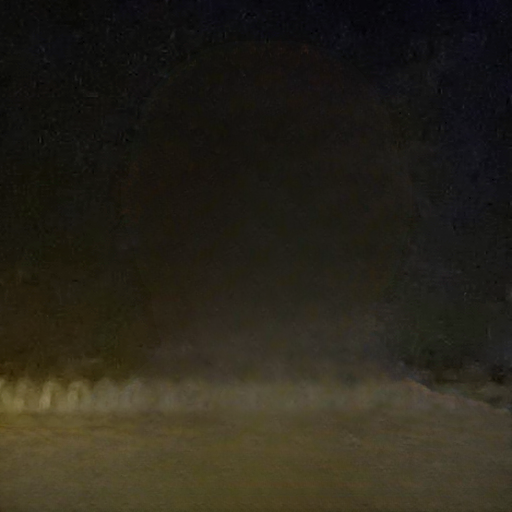


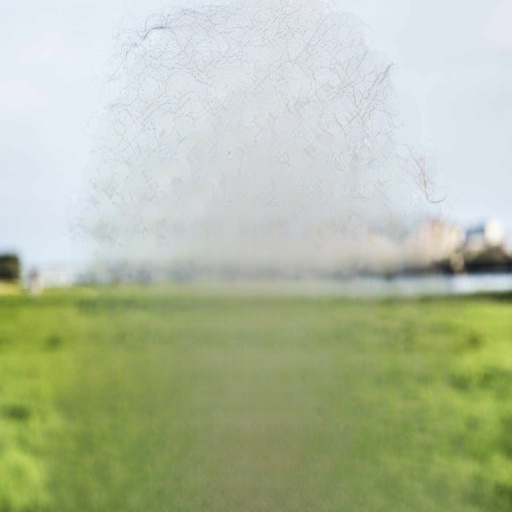


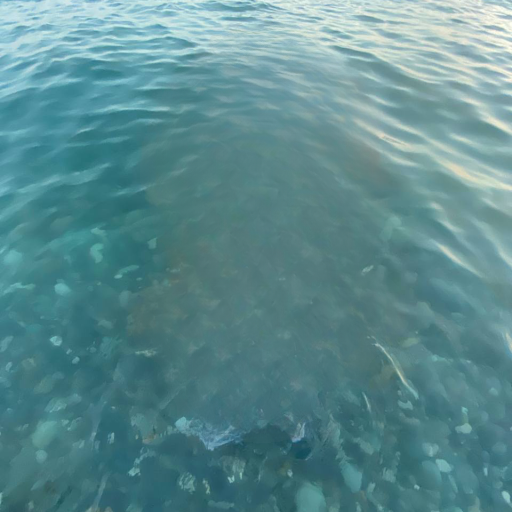

In [12]:
img_names = os.listdir(ASS)
img_pairs = []

for name in os.listdir(OUT):
    img = cv2.imread(f'{OUT}/{name}')
    img = img[:, 512*3:]
    display_img(img)